In [1]:
!pip install --upgrade wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 45.9 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.16.6
    Uninstalling wandb-0.16.6:
      Successfully uninstalled wandb-0.16.6


In [2]:
# Imports
import random
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from kaggle_secrets import UserSecretsClient
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

2024-05-24 13:07:12.305866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 13:07:12.305978: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 13:07:12.436959: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb-key")
wandb.login(key=wandb_api)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
from datasets import load_dataset

# Load dataset
dataset = load_dataset("garythung/trashnet")
# Check dataset
dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})

In [5]:
# Access the labels/classes 
label_names = dataset['train'].features['label'].names
print(f"Label names: {label_names}")

Label names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [6]:
# Convert to DataFrame for splitting
df = dataset['train'].to_pandas()

RANDOM_SEED = 2530

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Split the dataset with a fixed random state
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=RANDOM_SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=RANDOM_SEED)

# Convert back to Dataset objects
train_dataset = dataset['train'].from_pandas(train_df)
val_dataset = dataset['train'].from_pandas(val_df)
test_dataset = dataset['train'].from_pandas(test_df)

In [7]:
# Map actual names to labels
labels_names = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}
df['label'].value_counts().rename(index=labels_names)

label
paper        1188
glass        1002
plastic       964
metal         820
cardboard     806
trash         274
Name: count, dtype: int64

**It seems that the dataset have imbalanced class**

In [8]:
train_df['label'].value_counts()

label
3    950
1    802
4    771
2    656
0    645
5    219
Name: count, dtype: int64

In [9]:
val_df['label'].value_counts()

label
3    119
1    100
4     96
2     82
0     80
5     28
Name: count, dtype: int64

In [10]:
test_df['label'].value_counts()

label
3    119
1    100
4     97
2     82
0     81
5     27
Name: count, dtype: int64

In [11]:
# Preprocess function
def preprocess(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode the image
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize the image
    image = tf.image.resize(image, [224, 224])  # Resize to fixed size
    return image, label

# Preprocess function with py_function wrapper
def preprocess_with_py_function(image_path, label):
    image, label = tf.py_function(preprocess, [image_path, label], [tf.float32, tf.int64])
    image.set_shape((224, 224, 3))  # Set the shape of the image tensor
    label.set_shape(())  # Set the shape of the label tensor
    return image, label

# Convert Hugging Face Dataset to TensorFlow Dataset
def convert_to_tf_dataset(hf_dataset):
    def generator():
        for example in hf_dataset:
            yield example['image']['path'], example['label']
    
    return tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.int64)
        )
    ).map(preprocess_with_py_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Convert datasets
train_tf_dataset = convert_to_tf_dataset(train_dataset)
val_tf_dataset = convert_to_tf_dataset(val_dataset)
test_tf_dataset = convert_to_tf_dataset(test_dataset)

# Batch and prefetch datasets
batch_size = 64
train_tf_dataset = train_tf_dataset.shuffle(1000, seed=RANDOM_SEED).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_tf_dataset = val_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_tf_dataset = test_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
# Load MobileNetV2 pre-trained on ImageNet without the top classification layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the pre-trained layers
base_model.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

# Combine base model and custom head
model = Model(inputs=base_model.input, outputs=predictions)

# Initialize wandb
wandb.init(project='adamata-trashnet', entity='ghifariaulia')

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Define number of epochs
epochs = 10

# Train the model
history = model.fit(
    train_tf_dataset,
    epochs=epochs,
    validation_data=val_tf_dataset,
    callbacks=[wandb.keras.WandbMetricsLogger()]
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_tf_dataset)
print(f'Test accuracy: {test_acc}')

# Finish the wandb run
wandb.finish()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


wandb: Currently logged in as: ghifariaulia. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240524_130821-ewjm3chk
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run distinctive-galaxy-42
wandb: ⭐️ View project at https://wandb.ai/ghifariaulia/adamata-trashnet
wandb: 🚀 View run at https://wandb.ai/ghifariaulia/adamata-trashnet/runs/ewjm3chk


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
      2/Unknown 34s 65ms/step - accuracy: 0.2383 - loss: 1.9658

I0000 00:00:1716556155.051894     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     64/Unknown 92s 927ms/step - accuracy: 0.6229 - loss: 0.9782

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
wandb: ERROR Unable to log learning rate.


64/64 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.6245 - loss: 0.9740 - val_accuracy: 0.8495 - val_loss: 0.4348
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 996ms/step - accuracy: 0.8837 - loss: 0.3342 - val_accuracy: 0.8891 - val_loss: 0.3311
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9315 - loss: 0.2147 - val_accuracy: 0.8871 - val_loss: 0.2969
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 142s 994ms/step - accuracy: 0.9626 - loss: 0.1407 - val_accuracy: 0.9050 - val_loss: 0.2537
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 993ms/step - accuracy: 0.9840 - loss: 0.0839 - val_accuracy: 0.9307 - val_loss: 0.2083
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 84s 999ms/step - accuracy: 0.9948 - loss: 0.0531 - val_accuracy: 0.9228 - val_loss: 0.1989
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 975ms/step - accuracy: 0.9975 - loss: 0.0391 - val_accuracy: 0.9327 - val_loss: 0.1906
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 83s 993ms/step - accuracy: 0.9991 - loss: 0.0257 - val_accuracy: 0.9327 - 

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:     epoch/accuracy ▁▅▆▇██████
wandb:        epoch/epoch ▁▂▃▃▄▅▆▆▇█
wandb:         epoch/loss █▄▃▂▂▁▁▁▁▁
wandb: epoch/val_accuracy ▁▄▄▅▇▇▇▇██
wandb:     epoch/val_loss █▅▄▃▂▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:     epoch/accuracy 0.99827
wandb:        epoch/epoch 9
wandb:         epoch/loss 0.01748
wandb: epoch/val_accuracy 0.94059
wandb:     epoch/val_loss 0.1886
wandb: 
wandb: 🚀 View run distinctive-galaxy-42 at: https://wandb.ai/ghifariaulia/adamata-trashnet/runs/ewjm3chk
wandb: ⭐️ View project at: https://wandb.ai/ghifariaulia/adamata-trashnet
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240524_130821-ewjm3chk/logs


8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 939ms/step


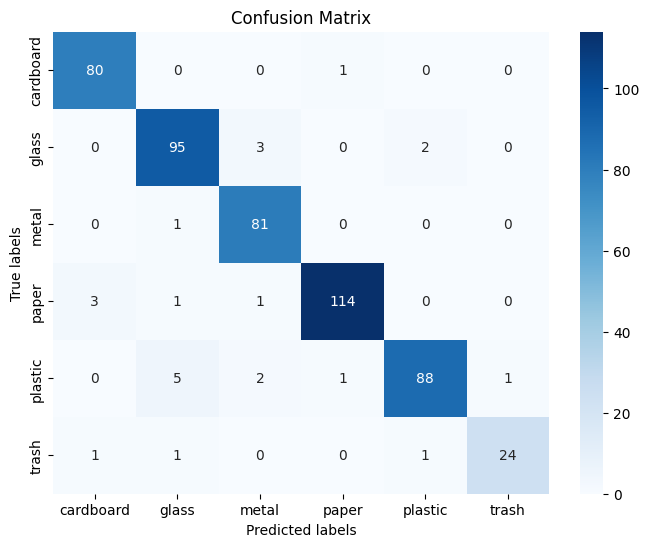

In [13]:
# Make predictions on the test dataset
predictions = model.predict(test_tf_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = np.concatenate([label for _, label in test_tf_dataset])

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Compute classification report
clr = classification_report(true_labels, predicted_labels, target_names=label_names, zero_division=0)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [14]:
print("Classification Report (Before oversampling):\n----------------------\n", clr)

Classification Report (Before oversampling):
----------------------
               precision    recall  f1-score   support

   cardboard       0.95      0.99      0.97        81
       glass       0.92      0.95      0.94       100
       metal       0.93      0.99      0.96        82
       paper       0.98      0.96      0.97       119
     plastic       0.97      0.91      0.94        97
       trash       0.96      0.89      0.92        27

    accuracy                           0.95       506
   macro avg       0.95      0.95      0.95       506
weighted avg       0.95      0.95      0.95       506



**The Model is performing quite well but the class imbalance might be affecting the model's performance, especially for the minority classes such as "trash," where the precision, recall, and F1-score are slightly lower compared to other classes.**

In [15]:
# Identify minority class
minority_class = 5 # trash

# Compute class counts
class_counts = Counter(df['label'])

# Determine oversampling ratio
minority_samples = class_counts[minority_class]
majority_samples = sum(count for label, count in class_counts.items() if label != minority_class)
oversampling_ratio = (majority_samples / minority_samples) - 15.51  # Adjusting the ratio

# Perform oversampling
minority_indices = np.where(df['label'] == minority_class)[0]
oversampled_indices = np.random.choice(minority_indices, size=int(oversampling_ratio * minority_samples), replace=True)
oversampled_data = df.iloc[oversampled_indices]

# Concatenate oversampled data with original data
oversampled_df = pd.concat([df, oversampled_data], axis=0)

# Shuffle the dataset
oversampled_df = oversampled_df.sample(frac=1).reset_index(drop=True)

# Check class distribution after oversampling
print(Counter(oversampled_df['label']))

Counter({3: 1188, 1: 1002, 4: 964, 2: 820, 0: 806, 5: 804})


In [16]:
oversampled_df['label'].value_counts().rename(index=labels_names)

label
paper        1188
glass        1002
plastic       964
metal         820
cardboard     806
trash         804
Name: count, dtype: int64

In [17]:
# Split the dataset
train_df, temp_df = train_test_split(oversampled_df, test_size=0.2, stratify=oversampled_df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'])

# Convert back to Dataset objects
train_dataset = dataset['train'].from_pandas(train_df)
val_dataset = dataset['train'].from_pandas(val_df)
test_dataset = dataset['train'].from_pandas(test_df)

In [18]:
# Convert datasets
train_tf_dataset = convert_to_tf_dataset(train_dataset)
val_tf_dataset = convert_to_tf_dataset(val_dataset)
test_tf_dataset = convert_to_tf_dataset(test_dataset)

# Batch and prefetch datasets
batch_size = 32
train_tf_dataset = train_tf_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_tf_dataset = val_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_tf_dataset = test_tf_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [19]:
# Load MobileNetV2 pre-trained on ImageNet without the top classification layer
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the pre-trained layers
base_model.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)  # Replace num_classes with the number of your classes

# Combine base model and custom head
model = Model(inputs=base_model.input, outputs=predictions)

# Initialize wandb
wandb.init(project='adamata-trashnet', entity='ghifariaulia')

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Define number of epochs
epochs = 10

# Train the model
history = model.fit(
    train_tf_dataset,
    epochs=epochs,
    validation_data=val_tf_dataset,
    callbacks=[wandb.keras.WandbMetricsLogger()]
)

# Save the entire model
model.save('mobilenetv2-trashnet.h5')


# Save only the weights
model.save_weights('mobilenetv2-trashnet.weights.h5')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_tf_dataset)
print(f'Test accuracy: {test_acc}')

wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240524_132431-992kf0ht
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run rare-deluge-43
wandb: ⭐️ View project at https://wandb.ai/ghifariaulia/adamata-trashnet
wandb: 🚀 View run at https://wandb.ai/ghifariaulia/adamata-trashnet/runs/992kf0ht


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
    140/Unknown 96s 489ms/step - accuracy: 0.6659 - loss: 0.8949

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


140/140 ━━━━━━━━━━━━━━━━━━━━ 110s 590ms/step - accuracy: 0.6666 - loss: 0.8931 - val_accuracy: 0.8118 - val_loss: 0.4755
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 89s 505ms/step - accuracy: 0.9027 - loss: 0.2911 - val_accuracy: 0.8817 - val_loss: 0.3588
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 91s 523ms/step - accuracy: 0.9441 - loss: 0.1784 - val_accuracy: 0.9194 - val_loss: 0.2554
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 92s 524ms/step - accuracy: 0.9774 - loss: 0.0882 - val_accuracy: 0.9194 - val_loss: 0.2309
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 91s 519ms/step - accuracy: 0.9907 - loss: 0.0516 - val_accuracy: 0.9391 - val_loss: 0.1925
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 89s 514ms/step - accuracy: 0.9981 - loss: 0.0283 - val_accuracy: 0.9444 - val_loss: 0.1986
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 92s 524ms/step - accuracy: 0.9974 - loss: 0.0242 - val_accuracy: 0.9570 - val_loss: 0.1849
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 91s 518ms/step - accuracy: 0.9984 - loss: 0.0170 - va

18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 551ms/step


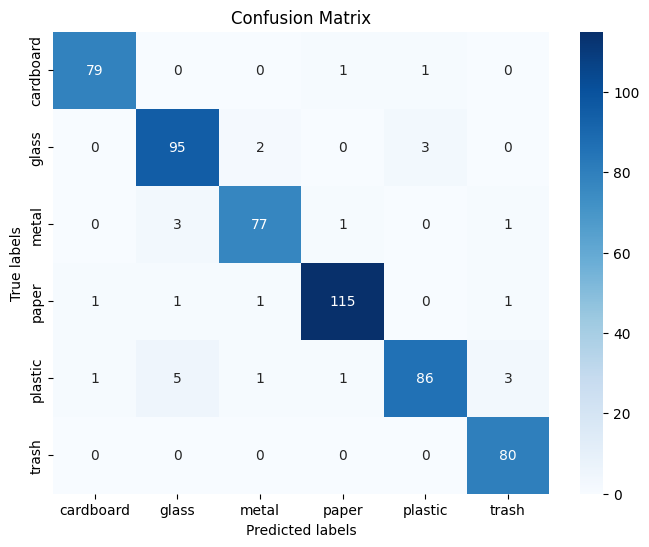

In [20]:
# Make predictions on the test dataset
predictions = model.predict(test_tf_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = np.concatenate([label for _, label in test_tf_dataset])

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Compute classification report
clr = classification_report(true_labels, predicted_labels, target_names=label_names, zero_division=0)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [21]:
print("Classification Report (After Oversampling):\n----------------------\n", clr)

Classification Report (After Oversampling):
----------------------
               precision    recall  f1-score   support

   cardboard       0.98      0.98      0.98        81
       glass       0.91      0.95      0.93       100
       metal       0.95      0.94      0.94        82
       paper       0.97      0.97      0.97       119
     plastic       0.96      0.89      0.92        97
       trash       0.94      1.00      0.97        80

    accuracy                           0.95       559
   macro avg       0.95      0.95      0.95       559
weighted avg       0.95      0.95      0.95       559



**After oversampling "trash" class, the model did better, the precision, recall, and f1-score for "trash" increased**

In [22]:
# Define the class names (replace these with your actual class names)
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Define a function to decode predictions
def decode_predictions(preds):
    return [class_names[np.argmax(pred)] for pred in preds]

# Loop through the test dataset and log predictions for each sample
for test_images, test_labels in test_tf_dataset:
    # Make predictions using the trained model
    predictions = model.predict(test_images)

    # Decode the predictions
    predicted_classes = decode_predictions(predictions)

    # Log predictions for each sample
    for i in range(len(test_images)):
        true_label = class_names[test_labels[i].numpy()]
        predicted_label = predicted_classes[i]
        sample_image = test_images[i].numpy()

        # Log the sample image, true label, and predicted label to wandb
        wandb.log({
            f"sample_image_{i}": [wandb.Image(sample_image, caption=f"True: {true_label}, Pred: {predicted_label}")],
            f"true_label_{i}": true_label,
            f"predicted_label_{i}": predicted_label
        })

# Finish the wandb run
wandb.finish()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:     epoch/accuracy ▁▅▇▇██████
wandb:        epoch/epoch ▁▂▃▃▄▅▆▆▇█
wandb:         epoch/loss █▄▃▂▁▁▁▁▁▁
wandb: epoch/val_accuracy ▁▄▆▆▇▇██▇█
wandb:     epoch/val_loss █▅▃▂▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:     epoch/accuracy 0.99776
wandb:        epoch/epoch 9
wandb:         epoch/loss 0.01492
wandb: epoch/val_accuracy 0.94982
wandb:     epoch/val_loss 0.18957
wandb:  predicted_label_0 trash
wandb:  predicted_label_1 plastic
wandb: predicted_label_10 paper
wandb: predicted_label_11 cardboard
wandb: predicted_label_12 trash
wandb: predicted_label_13 metal
wandb: predicted_label_14 plastic
wandb: predicted_label_15 plastic
wandb: predicted_label_16 plastic
wandb: predicted_label_17 paper
wandb: predicted_label_18 cardboard
wandb: predicted_label_19 trash
wandb:  predicted_label_2 metal
wandb: predicted_label_20 paper
wandb: predicted_label_21 cardboard
wandb: p